<a href="https://colab.research.google.com/github/eemlcommunity/PracticalSessions2022/blob/main/graphNets/%5Bsolved%5D_EEML_Graph_Nets_tutorial_13_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamics modelling using MPNNs

**Authors:** [Iulia Duță](https://iuliaduta.github.io/) and [Cătălina Cangea](https://catalinacangea.netlify.app/)

**Abstract:** This tutorial covers basic concepts from the field of Graph Representation Learning, such as:
* representing a graph structure in an ML setup;
* implementing Graph Neural Network (GNN) variants: [Graph Convolutional Network](https://arxiv.org/abs/1609.02907) (GCN), [Message Passing Neural Network](https://arxiv.org/pdf/1704.01212v2.pdf) (MPNN);
* learning to infer the structure of a graph.

**Outline of the tutorial:**
1. Create a dataset to simulate the movement of a set of particles.
2. Show how to represent graphs in memory.
3. Implement a GNN to predict the trajectories of the particles, given the _ground-truth graph connectivity_ (i.e. the edges of the graph).
4.  Implement a GNN to predict these trajectories, this time _assuming the graph is fully-connected_ (i.e. each node links to all others).
5. Learn to predict the connectivity using an encoder similar to the one used in the NRI ([Neural Relational Inference](https://arxiv.org/abs/1802.04687)) model.

# 😩 **Preliminaries:** Install and import modules

In [ ]:
import torch
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 407 kB 31.4 MB/s 
     |████████████████████████████████| 7.9 MB 29.1 MB/s 
     |████████████████████████████████| 3.5 MB 66.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=75b1074429d16c4c0f1cb14fcf2ff256a5d3b7320af925b88277f990f48c47a1
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
# @title [RUN] Imports

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data

import networkx as nx

from numpy import linspace
import random

from matplotlib import cm
from matplotlib.lines import Line2D 
   
import scipy.linalg
from scipy.linalg import block_diag

import pdb

In [ ]:
# @title [RUN] Helper functions for plots and visualisations

global_train_stats = {}
####### Helper functions for plots #######
def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_cumulate_stats(global_training_stats, training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    for key,val in training_stats.items():
      global_training_stats.update({f'{key}_{name}': val})
    stats_names = [key[6:] for key in global_training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            global_training_stats[f'epoch_{name}'],
            global_training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            global_training_stats[f'epoch_{name}'],
            global_training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)
    return global_training_stats
    
def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)

def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))
  

# 🚀 **Part 1:** Dataset of simulated particle movements


The tutorial focuses on solving a physics-inspired task: simulating the movement of a set of particles connected by strings. There are `n_balls` moving; these may or may not interact with equal probability, which determines the trajectories of the balls.

Our goal is to **use an observed part of the trajectory** to **predict what will happen in the future** and **recover the interactions**.

<!-- ![image](https://drive.google.com/uc?export=view&id=1pCoFuLCISrbL59DS--KHcwBagANFYjPy){ width=5% } -->

<img src="https://drive.google.com/uc?export=view&id=1pCoFuLCISrbL59DS--KHcwBagANFYjPy"  width="200" height="200">

During this tutorial, we will vary the amount of information that we receive about particle interactions, process this information using Graph Neural Networks and analyse how the trajectory prediction is influenced by this choices.

In turn, we will:

* use the **ground-truth connectivity**;
* assume interactions take place between all pairs of particles (**fully-connected interaction graph**);
* **predict** the interactions (NRI-like).



In [ ]:
#@title [RUN] A springs trajectory simulator class

import numpy as np
import matplotlib.pyplot as plt
import time


class SpringSim(object):
    def __init__(self, n_balls=5, box_size=5., loc_std=.5, vel_norm=.5,
                 interaction_strength=.1, noise_var=0.):
        self.n_balls = n_balls
        self.box_size = box_size
        self.loc_std = loc_std
        self.vel_norm = vel_norm
        self.interaction_strength = interaction_strength
        self.noise_var = noise_var

        self._spring_types = np.array([0., 0.5, 1.])
        self._delta_T = 0.001
        self._max_F = 0.1 / self._delta_T

    def _energy(self, loc, vel, edges):
        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):

            K = 0.5 * (vel ** 2).sum()
            U = 0
            for i in range(loc.shape[1]):
                for j in range(loc.shape[1]):
                    if i != j:
                        r = loc[:, i] - loc[:, j]
                        dist = np.sqrt((r ** 2).sum())
                        U += 0.5 * self.interaction_strength * edges[
                            i, j] * (dist ** 2) / 2
            return U + K

    def _clamp(self, loc, vel):
        '''
        :param loc: 2xN location at one time stamp
        :param vel: 2xN velocity at one time stamp
        :return: location and velocity after hiting walls and returning after
            elastically colliding with walls
        '''
        assert (np.all(loc < self.box_size * 3))
        assert (np.all(loc > -self.box_size * 3))

        over = loc > self.box_size
        loc[over] = 2 * self.box_size - loc[over]
        assert (np.all(loc <= self.box_size))

        # assert(np.all(vel[over]>0))
        vel[over] = -np.abs(vel[over])

        under = loc < -self.box_size
        loc[under] = -2 * self.box_size - loc[under]
        # assert (np.all(vel[under] < 0))
        assert (np.all(loc >= -self.box_size))
        vel[under] = np.abs(vel[under])

        return loc, vel

    def _l2(self, A, B):
        """
        Input: A is a Nxd matrix
               B is a Mxd matirx
        Output: dist is a NxM matrix where dist[i,j] is the square norm
            between A[i,:] and B[j,:]
        i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
        """
        A_norm = (A ** 2).sum(axis=1).reshape(A.shape[0], 1)
        B_norm = (B ** 2).sum(axis=1).reshape(1, B.shape[0])
        dist = A_norm + B_norm - 2 * A.dot(B.transpose())
        return dist

    def sample_trajectory(self, T=10000, sample_freq=10,
                          spring_prob=[1. / 2, 0, 1. / 2]):
        n = self.n_balls
        assert (T % sample_freq == 0)
        T_save = int(T / sample_freq - 1)
        diag_mask = np.ones((n, n), dtype=bool)
        np.fill_diagonal(diag_mask, 0)
        counter = 0
        # Sample edges
        edges = np.random.choice(self._spring_types,
                                 size=(self.n_balls, self.n_balls),
                                 p=spring_prob)
        edges = np.tril(edges) + np.tril(edges, -1).T
        np.fill_diagonal(edges, 0)
        # Initialize location and velocity
        loc = np.zeros((T_save, 2, n))
        vel = np.zeros((T_save, 2, n))
        loc_next = np.random.randn(2, n) * self.loc_std
        vel_next = np.random.randn(2, n)
        v_norm = np.sqrt((vel_next ** 2).sum(axis=0)).reshape(1, -1)
        vel_next = vel_next * self.vel_norm / v_norm
        loc[0, :, :], vel[0, :, :] = self._clamp(loc_next, vel_next)

        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):

            forces_size = - self.interaction_strength * edges
            np.fill_diagonal(forces_size,
                             0)  # self forces are zero (fixes division by zero)
            F = (forces_size.reshape(1, n, n) *
                 np.concatenate((
                     np.subtract.outer(loc_next[0, :],
                                       loc_next[0, :]).reshape(1, n, n),
                     np.subtract.outer(loc_next[1, :],
                                       loc_next[1, :]).reshape(1, n, n)))).sum(
                axis=-1)
            F[F > self._max_F] = self._max_F
            F[F < -self._max_F] = -self._max_F

            vel_next += self._delta_T * F
            # run leapfrog
            for i in range(1, T):
                loc_next += self._delta_T * vel_next
                loc_next, vel_next = self._clamp(loc_next, vel_next)

                if i % sample_freq == 0:
                    loc[counter, :, :], vel[counter, :, :] = loc_next, vel_next
                    counter += 1

                forces_size = - self.interaction_strength * edges
                np.fill_diagonal(forces_size, 0)
                # assert (np.abs(forces_size[diag_mask]).min() > 1e-10)

                F = (forces_size.reshape(1, n, n) *
                     np.concatenate((
                         np.subtract.outer(loc_next[0, :],
                                           loc_next[0, :]).reshape(1, n, n),
                         np.subtract.outer(loc_next[1, :],
                                           loc_next[1, :]).reshape(1, n,
                                                                   n)))).sum(
                    axis=-1)
                F[F > self._max_F] = self._max_F
                F[F < -self._max_F] = -self._max_F
                vel_next += self._delta_T * F
            # Add noise to observations
            loc += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            vel += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            return loc, vel, edges


Above, we provide the class that implements a particle trajectory simulator. 

For training, we generate `num_train_sims` trajectories, each one containing `n_balls` objects, observed for a `trajectory_length` seconds, and we record the position (_x,y_ coordinates) after every `sample_every_n_steps` seconds.

For validation, we will generate the data similarly, but restricting the generation to only `num_valid_sims` trajectories.

For test, we generate `num_test_sims`; here, each trajectory is observed instead for `test_trajectory_length` (which should be at least 2 $\times$ `trajectory_length`).

Let's now generate datasets containing these trajectories. Depending on the parameters, running this code might take some time... ⏳⌛️

⚠️ NOTE: we have already provided a generated dataset containing 45,000 trajectories for training and 200 validation/test trajectories. In order to use that dataset instead, you should:

1. Download the `.pkl` file from `github`.
2. Upload the file into your Google Drive.
3. Change the file path `save_data_file_name` in the following script to point to the location in your Google Drive where you saved the file.
4. Run the script with `load_existing_dataset=True` (running the script will require you to give access rights to your Google Drive account).

In [ ]:
#@title Create a simulated spring trajectory dataset

# This flag set to true will disable all the other params
# and load the existing dataset stored in path instead
load_existing_dataset = True#@param {type:"boolean"}
save_data_file_name = '/content/gdrive/MyDrive/'+ f'dataset_combined.pkl'

# Parameters for generating the dataset
n_balls = 4 #@param {type:"integer"}
num_train_sims =  1000#@param {type:"integer"}
num_valid_sims =  200#@param {type:"integer"}
num_test_sims =  200#@param {type:"integer"}
trajectory_length = 5000 #@param {type:"integer"}
test_trajectory_length = 10000 #@param {type:"integer"}
sample_every_n_steps = 100 #@param {type:"integer"}


assert trajectory_length % sample_every_n_steps == 0, \
    "`trajectory_length` needs to be divisible by `sample_every_n_steps`"
assert test_trajectory_length % sample_every_n_steps == 0, \
    "`test_trajectory_length` needs to be divisible by `sample_every_n_steps`"

sim = SpringSim(noise_var=0.0, n_balls=n_balls)

def generate_dataset(num_sims, length, sample_freq):
    loc_all = list()
    vel_all = list()
    edges_all = list()

    for i in range(num_sims):
        t = time.time()
        loc, vel, edges = sim.sample_trajectory(T=length,
                                                sample_freq=sample_freq)
        if i % 100 == 0:
            print("Iter: {}, Simulation time: {}".format(i, time.time() - t))
        loc_all.append(loc)
        vel_all.append(vel)
        edges_all.append(edges)

    loc_all = np.stack(loc_all)
    vel_all = np.stack(vel_all)
    edges_all = np.stack(edges_all)

    return loc_all, vel_all, edges_all

if load_existing_dataset == False:
    print("Generating {} training simulations".format(num_train_sims))
    loc_train, vel_train, edges_train = generate_dataset(num_train_sims,
                                                        trajectory_length,
                                                        sample_every_n_steps)

    print("Generating {} validation simulations".format(num_valid_sims))
    loc_valid, vel_valid, edges_valid = generate_dataset(num_valid_sims,
                                                        trajectory_length,
                                                        sample_every_n_steps)

    print("Generating {} test simulations".format(num_test_sims))
    loc_test, vel_test, edges_test = generate_dataset(num_test_sims,
                                                      test_trajectory_length,
                                                      sample_every_n_steps)

    for (loc, vel, edges, num_sims) in [
        (loc_train, vel_train, edges_train, num_train_sims),
        (loc_valid, vel_valid, edges_valid, num_valid_sims),
        (loc_test, vel_test, edges_test, num_test_sims),
    ]:
      ls = loc.shape
      assert (ls[0] == num_sims and
              ls[1] == trajectory_length // sample_every_n_steps - 1 and
              ls[-1] == n_balls)
      vs = vel.shape
      assert ls == vs
      es = edges.shape
      assert es[0] == num_sims and es[1] == n_balls and es[2] == n_balls
else:
    import pickle
    from google.colab import drive
    drive.mount('/content/gdrive')

    with open(save_data_file_name, 'rb') as fo:
        saved_data = pickle.load(fo)
        loc_train = saved_data['loc_train']
        vel_train = saved_data['vel_train']
        edges_train = saved_data['edges_train']
        loc_valid = saved_data['loc_valid']
        vel_valid = saved_data['vel_valid']
        edges_valid = saved_data['edges_valid']
        loc_test = saved_data['loc_test']
        vel_test = saved_data['vel_test']
        edges_test = saved_data['edges_test']

Mounted at /content/gdrive


In [ ]:
#@title Create the train-val-test splits

# Split the trajectories (x,y coordinates) 
# into inputs and targets. Target is the same as 
# the input, but shifted with 1 (temporal) position

loc_train_inputs, loc_train_targets = (
    loc_train[:, :-1, :, :], loc_train[:, 1:, :, :])
loc_valid_inputs, loc_valid_targets = (
    loc_valid[:, :-1, :, :], loc_valid[:, 1:, :, :])
loc_test_inputs, loc_test_targets = (
    loc_test[:, :-1, :, :], loc_test[:, 1:, :, :])

# loc_{split}_inputs.shape: 
# n_samples x n_timesteps x 2(x,y coords) x n_balls
print("training data shape: ", loc_train_inputs.shape, loc_train_targets.shape, edges_train.shape)
print("valid data shape: ", loc_valid_inputs.shape, loc_valid_targets.shape, edges_valid.shape)
print("test data shape:", loc_test_inputs.shape, loc_test_targets.shape, edges_valid.shape)

training data shape:  (45001, 48, 2, 4) (45001, 48, 2, 4) (45001, 4, 4)
valid data shape:  (200, 48, 2, 4) (200, 48, 2, 4) (200, 4, 4)
test data shape: (200, 98, 2, 4) (200, 98, 2, 4) (200, 4, 4)


👀 Let's see what the trajectories look like. 


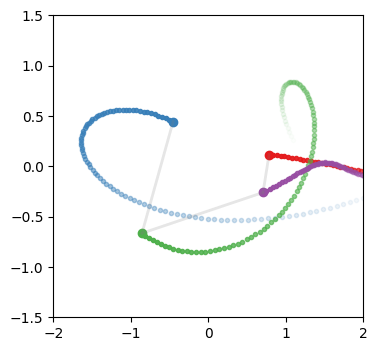

In [ ]:
#@title Plot one of the trajectories

plt.figure(figsize=(4, 4), dpi=100)
axes = plt.gca()
axes.set_xlim([-2, 2])
axes.set_ylim([-1.5, 1.5])

which_set =  "test" #@param {type:"string"} ["train", "valid", "test"]
example_index =  2#@param {type:"integer"}


if which_set == "train":
  loc, vel, edges = loc_train, vel_train, edges_train
elif which_set == "val":
  loc, vel, edges = loc_valid, vel_valid, edges_valid
else:
  loc, vel, edges = loc_test, vel_test, edges_test
assert example_index >= 0 and example_index < loc.shape[0], \
    "Need valid dataset index!"
loc, vel, edges = loc[example_index], vel[example_index], edges[example_index]


start = 0.0
stop = 1.0
number_of_lines= 10
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.Set1(x) for x in cm_subsection ]

def softplus(x):
    return np.log(1.0 + np.exp(x))

for i in range(loc.shape[-1]):
    for t in range(loc.shape[0]):
        plt.plot(loc[t, 0, i], loc[t, 1, i], 'o', markersize=3, color=colors[i], alpha=1 -(float(t)/loc.shape[0]))
    plt.plot(loc[0, 0, i], loc[0, 1, i], 'o', color=colors[i])
  
x,y = np.where(edges)
edges_all = np.vstack((x,y)).T

for i, edge in enumerate(edges_all):
    axes.add_line(Line2D([loc[0, 0, edge[0]], 
                    loc[0, 0, edge[1]]], 
                   [loc[0, 1, edge[0]], 
                    loc[0, 1, edge[1]]], 
                   linewidth=2, color='grey', alpha=0.1))

plt.savefig("springs.pdf")

📜  To sum up, we now have access to the following variables, for each `split` $\in$ `{train, valid, test}`: \\
  - `loc_{split}_inputs`: positions for the input data `(n_samples x n_timesteps x 2 x n_balls)` \\
  - `loc_{split}_targets`: positions for the target data (inputs shifted by 1 position) `(n_samples x n_timesteps x 2 x n_balls)` \\
  - `edges_{split}`: the ground-truth connectivity used by the simulation (constant across the entire trajectory)` (n_samples x n_balls x n_balls)`


# 🕸 Part 2: Representing graphs

A graph is a mathematical structure described as a tuple $\mathcal{G} = (V, E)$, where $V$ is a set of nodes and $E \subseteq (V \times V$) is the set of edges in the graph. Each pair $(u,v) \in E$ indicates that nodes $u$ and $v$ are connected.




---

**Graph input.** For a graph we represent the node 
features as a matrix $X \in \mathbb{R}^{n \times d}$, where 
each row $x_i \in \mathbb{R}^d$ represents the features for node $u_i$. 

To describe the graph connectivity, we can use an **adjacency matrix** $A \in \mathbb{R}^{n \times n}$ where $a_{i,j} = 1$ if there is an edge between nodes $u_i$ and $u_j$, and $a_{i,j} = 0$ otherwise.

Another - more compact way - of representing the connectivity is through an **adjacency list** $E \in \mathbb{R}^{2 \times m}$, where $m$ represents the number of edges and $(u_i, u_j) \in E$ indicates an edge between nodes $u_i$ and $u_j$.

**Graph output.** Depending on the problem that we want to solve, graph tasks may be split into 3 categories:

* **node-level** classification: we predict an output for each node (left);
* **edge-level** classification: we predict an output for each edge (center).
* **graph-level** classification: we predict a single output for the entire graph (right);


<img src="https://drive.google.com/uc?export=view&id=1ZGdGCzR6MmQnQZuH__I5JltannhHfjem"  width="800">

<details>
<summary> 💻 <b>Q:</b> Which category does the dynamic modeling of moving particles belong to? </summary>

 **A:** Our dynamic prediction task aims to output the position of each object at each time step in the future. Thus, we can model this as a **node-level classification problem**.
</details>


**`Data` structure.** To process the data more easily, we will use the [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) structure from [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), designed to store graph-structured information, and [`torch_geometric.data.Dataset`](...), designed to create custom graph datasets.

The code

> `graph = Data(x=x, y=y, edge_index=edge_index, ...)`

creates a graph with features `x`, labels `y` and the connectivity described as an _adjacency list_ `edge_index`.



In [ ]:
from torch_geometric.data import Data

# Use the Data structure to create a sample graph.
graph = Data(x=torch.rand((3,32)), 
               y=torch.rand((1)), 
               edge_index=torch.tensor([[0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]]))

print(graph)
print("Number of nodes:", graph.num_nodes)
print("Shape of node features:", graph.x.shape)
print("Shape of node labels:", graph.y.shape)

Data(x=[3, 32], edge_index=[2, 9], y=[1])
Number of nodes: 3
Shape of node features: torch.Size([3, 32])
Shape of node labels: torch.Size([1])


**`SpringDataset` structure.** For our custom `SpringDataset` class, we have to implement the following functions:

* the constructor, which will provide the input location, target location and the connectivity for all the trajectories in the dataset:

> `__init__(self, loc_inputs, loc_targets, edges_train, f)`

* a function to indicate the number of samples in the dataset:

> `__len__(self)`

* a getter function:

> `__getitem__(self, idx)`

that returns the `idx'`th trajectory of the dataset, in the form of a single graph: `Data(edge_index=edge_index, x=x, y=y, timesteps=timesteps)`, where $x \in \mathbb{R}^{n_{nodes}~\times~(dim~*~n_{timesteps})}$, $y \in \mathbb{R}^{n_{nodes}~\times~dim~\times~n_{timesteps}}$ and $\textit{edge}\_{\textit{index}} \in{\mathbb{R}^{2~\times~n_{edges}}}$ denotes the connectivity for the entire trajectory. 

⚠️ **Note:** The input for our model is a sequence of graphs describing the observed trajectory at each time step. However, in our `SpringDataset`, instead of having a sequence of graphs, one for each timestep, we represent the entire trajectory as a _single graph_, where the node features associated with each node $i$ store information about node $i$ along the entire sequence: $x_i \in \mathbb{R}^{dim~*~n_{\textit{timesteps}}}$. This works since the graph connectivity does not change along the trajectory.

🧪 Let's create the datasets based on the trajectories generated above:

In [ ]:
from torch_geometric.data import Dataset

class SpringDataset(Dataset):
    """ Dataset to store Spring trajectories. """

    def __init__(self, loc_inputs, loc_targets, edges, timesteps):
        """
        Args:
            loc_inputs: location for the input sequence n_sample x n_timesteps x dim x n_nodes
            loc_targets: location for the target sequence n_sample x n_timesteps x dim x n_nodes
            edges: node connectivity for each trajectory: n_sample x n_nodes x n_nodes
            timesteps: the length of the trajectory
        """
        super(SpringDataset, self).__init__()

        self.dim = loc_targets.shape[2]
        # -> n_samples x n_nodes x dim x n_timesteps
        loc_targets = np.transpose(loc_targets,[0,3,2,1]) 

        # Stack the features for all timesteps, s.t. we can describe the entire
        # trajectory as a single graph:
        # loc_*: n_samples x n_timesteps x dim x n_nodes ->
        #        n_samples x n_nodes x dim x n_timesteps -> 
        #        n_samples x n_nodes x (dim x n_timesteps).
        loc_inputs = np.transpose(loc_inputs,[0,3,2,1])
        loc_inputs = loc_inputs.reshape((loc_inputs.shape[0], loc_inputs.shape[1], -1))
        
        self.edges = edges
        self.loc_inputs = loc_inputs
        self.loc_targets = loc_targets
        self.timesteps = timesteps

    def __len__(self):
        return self.edges.shape[0]

    def __getitem__(self, idx):
        crt_edge_adj = self.edges[idx]
        crt_loc_inputs = self.loc_inputs[idx]
        crt_loc_targets = self.loc_targets[idx]

        # Convert the adjacency matrix to an adjacency list.
        edge_index = torch.tensor(np.array(np.where(crt_edge_adj)))
        x = torch.tensor(crt_loc_inputs).to(torch.float32) 
        y = torch.tensor(crt_loc_targets).to(torch.float32) 

        # Create a graph with `x` as features, `y` as labels and its
        # connectivity given by `edge_index`.
        graph = Data(edge_index=edge_index, x=x, y=y, timesteps=self.timesteps)
        return graph

In [ ]:
import pdb
from torch_geometric.data import Data, DataLoader
# Create one dataset for each split and one data loader for each dataset.

BATCH_SIZE = 64#@param {type:"integer"}
DEVICE = 'cuda'#@param {type:"string"}

timesteps = loc_train_targets.shape[1]
train_dataset = SpringDataset(loc_train_inputs, loc_train_targets, edges_train, timesteps)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = SpringDataset(loc_valid_inputs, loc_valid_targets, edges_valid, timesteps)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# The test trajectories should be at least 2 times as long as the train/val ones
test_dataset = SpringDataset(loc_test_inputs, loc_test_targets, edges_test, 2*timesteps)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Let's explore what we generated:

In [ ]:
# This is a Data object containing the first graph in the train dataset.
one_sample_graph = train_dataset[0] 

# This is a Data object containing a batch of graphs.
_, batch_graph = next(enumerate(train_loader))

print("Num nodes for one graph: ", one_sample_graph.num_nodes)
print("Num nodes for one batch: ", batch_graph.num_nodes)


Num nodes for one graph:  4
Num nodes for one batch:  256


<details>
<summary> 💻 <b>Q:</b> In our setup, a single batch represents a list of `batch_size` graphs (trajectories). However, when extracting a batch using the Pytorch Geometric `DataLoader`, the output - `batch_graph` - is a single graph (stored in a `Data` object). Why do you think this is the case? </summary>

 **A:** The way mini-batching works in Graph Neural Networks is by creating a big, sparse graph by concatenating `batch_size` disconnected graphs. For more information please take a look at the next section 😉.
</details>


## 🔆 Optional: Graph mini-batching

Since we wish to process several graphs at once, we need to store them in batches, to make the computation as efficient as possible. In some cases, creating batches is easy. For example, 32×32 images are straightforward to batch because they have the same width and height - resulting in a tensor of dimension  $\textit{batch_size}~\times~32~\times~32$). On the other hand, graphs have different numbers of nodes, which yields adjacency matrices with different shapes.

One solution for this is to create a single sparse graph as the union of all the graphs in the mini-batch as follow:

1. stack the features  𝑥  for all the nodes in all the graphs;

2. stack the labels  𝑦  for all the nodes in all the graphs

3. stack all the adjacency matrices  𝐴𝑖  as diagonal blocks in the new adjacency matrix;

This way, we will obtain a new graph containing  $\sum_{b=1}^{B}|V_i|$  nodes, where $B$  is the batch_size and by  $|V_i|$  we denote the number of nodes in graph $i$ . Note that since no edges connect nodes from different graphs, the information propagation will not be affected by the way we store it.

<center>
<img src="https://drive.google.com/uc?export=view&id=1RwI0CYA57S0OgLxgHgV6PBFNG9tnGvGR" width="500">
</center>

<center>
<img src="https://drive.google.com/uc?export=view&id=1Ux65wTJLXCfJ4TI4Up4mCHkaSja8NgrJ" width="500">
</center>


As you can see, the resulting matrix contains many zeros (sparse), thus storing the adjacency matrix as a sparse tensor can significantly improve the efficiency.

Until now, we have a way to store the graphs in a mini-batch such that they could be efficiently processed. 

However, we need to also be able to extract information from this structure, to recover the graphs that it contains. For this, we need to remember what initial graph each node belongs to.

We will do this by storing a list of indices `(self.batch)`, which map each node in the batch-graph to the initial graph it belong to. For example `batch=[0,0,0,1,1,2,2,2]` indicates that first 3 nodes belong to $G_0$, the next 2 nodes belong to $G_1$ and the last 3 nodes belong to $G_2$.

> ⚠️ Luckily all of these are already implemented in Dataset class, so we don't have to implement it from scratch. Let have a look!

In [ ]:
# Show statistics about the new graph built from this batch of graphs.
_, batch_graph = next(enumerate(train_loader))

print(f"Batch number_of_nodes: {batch_graph.num_nodes}")
print(f"Batch features shape: {batch_graph.x.shape}")
print(f"Batch labels shape: {batch_graph.y.shape}")

print(f"Batch indices for reconstruction: {batch_graph.batch.numpy()}")

Batch number_of_nodes: 256
Batch features shape: torch.Size([256, 96])
Batch labels shape: torch.Size([256, 2, 48])
Batch indices for reconstruction: [ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 22 22 22 22 23 23 23 23
 24 24 24 24 25 25 25 25 26 26 26 26 27 27 27 27 28 28 28 28 29 29 29 29
 30 30 30 30 31 31 31 31 32 32 32 32 33 33 33 33 34 34 34 34 35 35 35 35
 36 36 36 36 37 37 37 37 38 38 38 38 39 39 39 39 40 40 40 40 41 41 41 41
 42 42 42 42 43 43 43 43 44 44 44 44 45 45 45 45 46 46 46 46 47 47 47 47
 48 48 48 48 49 49 49 49 50 50 50 50 51 51 51 51 52 52 52 52 53 53 53 53
 54 54 54 54 55 55 55 55 56 56 56 56 57 57 57 57 58 58 58 58 59 59 59 59
 60 60 60 60 61 61 61 61 62 62 62 62 63 63 63 63]


# 👶🏻 Part 3: Coding our first GNN - a Graph Convolutional Network!

In order to process the information about particle trajectories, we need a model that can understand and process graph-like inputs. There are multiple flavours of Graph Neural Networks in the literature. We will start with one of the simplest ones: the [Graph Convolutional Network](https://arxiv.org/abs/1609.02907)(GCN).

A GCN layer implements the following update rule:

$\mathbf{X_{k+1}} = MLP_k \big( \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{X_k} \big)$,

where $\mathbf{A}$ is the adjacency matrix, $\mathbf{\tilde{A}} = \mathbf{A} + \mathbf{I}$ and $\mathbf{\tilde{D}}$ is the degree matrix of $\mathbf{\tilde{A}}$.

Under the hood, this means that:
* messages sent by all _incoming_ neighbours are aggregated by averaging
* an MLP projection is then applied.

The degree matrix $\mathbf{\tilde{D}}$ is used to normalised the adjacency matrix, which helps keep the computation more stable.

In [ ]:
def get_adjacency_matrix(edge_index, num_nodes):
    """ Creates an n_nodes x n_nodes adjacency matrix from the adjacency list.

    Args:
      edge_index: 2 x n_edges tensor containing the adjacency list
      num_nodes: number of nodes
    Return:
      a_tilde: n_nodes x n_nodes tensor representing the adj matrix + self-loops
    """
    eye_matrix = torch.eye(num_nodes).to(DEVICE)
    a_tilde = torch.sparse.LongTensor(edge_index, 
                          # The A matrix is binary, where 1 indicates an edge.
                          torch.ones((edge_index.shape[1])).to(DEVICE), 
                          torch.Size((num_nodes, num_nodes))
                          ).to_dense() + eye_matrix
    return a_tilde

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    """A simple GCN layer implementing the MLP(AX) update rule."""

    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int):
        super(GCNLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
    
        self.linear1 = nn.Linear(self.in_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, self.out_feats)

    def forward(self, x, adj_matrix): 
        """ 
          x: n_timesteps x n_nodes x in_feats (feats for one mini-batch graph)
          adj_matrix: n_nodes x n_nodes (adj for one mini-batch graph)
        
          out: n_timesteps x n_nodes x out_feats
        """

        # TASK: aggregate neighbouring messages: D^{-1/2}AD^{-1/2}X
        #  ============ YOUR CODE HERE  ============
        # x = ...
        D_tilde = torch.diag(torch.sum(adj_matrix, axis=1))
        D_tilde_inv_sqrt = torch.pow(D_tilde, -0.5)
        D_tilde_inv_sqrt[torch.isinf(D_tilde_inv_sqrt)] = 0.0
        adj_matrix = torch.matmul(torch.matmul(D_tilde_inv_sqrt, adj_matrix), D_tilde_inv_sqrt)
        adj_matrix = adj_matrix.unsqueeze(0).tile((x.shape[0],1,1))
        x = torch.bmm(adj_matrix, x)
        # ==========================================

        # TASK: update the node features using a 2-layer MLP: (MLP_k(X))
        #  ============ YOUR CODE HERE  ============
        # out = ...
        x = self.linear1(x)
        x = F.relu(x)
        out = self.linear2(x)
        # ==========================================
        return out

Let's create a Neural Network that uses GCN Layers, in order to predict the change in position $\Delta x$:

In [ ]:
from torch.nn.modules.linear import Linear
class SimpleGCN(nn.Module):
    """ Simple GCN network containing num_layers GCN layers. """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, adj_type="gt"):
        super(SimpleGCN, self).__init__()
        # Selects between ground-truth(`gt`) or fully-connected (`fully_graph`)
        # node connectivity.
        self.adj_type = adj_type
        assert adj_type in ['gt', 'fully_graph']
        
        self.num_layers = num_layers 
        assert self.num_layers >= 2

        # Projects the spatial coordinates (x,y) into a larger space.
        self.embed_x = Linear(input_dim, hidden_dim)

        # TASK: instantiate (num_layers) GCNLayer(s), each with different parameters
        #  ============ YOUR CODE HERE  ============
        # self.layers = [...]
        self.layers = [GCNLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [GCNLayer(hidden_dim, output_dim, hidden_dim)]
        # ==========================================
        self.layers = nn.ModuleList(self.layers)

    def forward(self, input, adj_matrix):
        # x: n_timesteps x n_nodes x input_dim
        x = self.embed_x(input)

        for i in range(self.num_layers-1):
          x = self.layers[i](x, adj_matrix)
          x = F.relu(x)
        x = self.layers[-1](x, adj_matrix)
        
        # We are predictring the shift in position dx, not the future position.
        # To obtain the next prediction, we add the input position.
        out = input + x

        # out: n_timesteps x n_nodes x output_dim
        return out

⚠️ Note that, since we are interested in solving a **node-level** classification problem, obtaining a prediction for each node is enough. For a **graph-level** classification task, an additional operation which aggregates the information from the entire graph (such as max or mean pooling) would have been necessary.

## 🛠 Training the network for dynamic prediction


In [ ]:
INPUT_DIM = 2
OUTPUT_DIM = 2
TIMESTEPS = 48

In the physics simulations used to generate our dataset, we assume that the dynamics is Markovian, meaning that we can predict the next step base solely on the last observation. 

During training, we will thus optimise the network to predict the node features at timestep $t+1$, given the features from timestep $t$. We achieve this by considering `input[0:t]` as input and `input[1:t+1]` as target (see `forward_step_teacher_forcing `function). 

In [ ]:
def forward_step_teacher_forcing(batch, model):
    """ One feed-forward step with teacher-forcing (used during TRAINING).

    During training, we use a teacher-forcing approach: at each time step t, we
    feed as input the real position from the previous timestep t-1.

    Output: (pred, target) tuple.
    """
    if model.adj_type == 'gt':
        # TASK: create an adjacency matrix from the ground-truth connectivity
        # Hint: the ground truth graph is stored in `batch.edge_index` and 
        # you can use the already-implemented `get_adjacency_matrix()`.
        #  ============ YOUR CODE HERE  ============
        # adj_matrix = ..
        adj_matrix = get_adjacency_matrix(batch.edge_index, batch.num_nodes)
        # ==========================================
    elif model.adj_type == 'fully_graph':
        # TASK: create an adjacency matrix for the fully-connected graph 
        #  ============ YOUR CODE HERE  ============
        # adj_matrix = ..
        adj_matrix = torch.ones((batch.num_nodes, batch.num_nodes)).to(DEVICE)
        #if we are in a batch not in a sg graph
        if batch.batch is not None:
          tozero = batch.batch.unsqueeze(0) != batch.batch.unsqueeze(1)
          diag_ids = torch.arange(adj_matrix.shape[0])
          adj_matrix[tozero] = 0
          adj_matrix[diag_ids, diag_ids] = 0
        # adj_matrix = torch.ones((batch.num_nodes, batch.num_nodes)).to(DEVICE)
        # ==========================================

    # Separate the timesteps dimension:
    # n_nodes x (dim * n_timesteps) ->  n_nodes x dim x n_timesteps
    feats = batch.x.reshape(batch.x.shape[0], INPUT_DIM, -1)
    feats = torch.permute(feats, [2,0,1])

    # Run the forward pass for GNN.
    
    # y_hat: n_timesteps x n_nodes x output_dim
    y_hat  = model(feats, adj_matrix)
    # y_hat: n_nodes x output_dim x n_timesteps
    y_hat = y_hat.permute((1,2,0))
    return y_hat, batch.y

For the evaluation, we only have access to the initial part of the trajectory. So we will evaluate the model step by step, by feeding as input for timestep $t$ the prediction obtained at timestep $t-1$, instead of the ground-truth position. (see `forward_step_pred` function)

In [ ]:
def forward_step_pred(batch, model, timesteps=TIMESTEPS):
    """ One feed-forward step using previous predictions as input (EVAL only),
    
    Run for the first `timesteps` positions in the input.

    Output: (pred, target) tuple.
    """
    if model.adj_type == 'gt':
        # TASK: create an adjacency matrix from the ground-truth connectivity
        # Hint: the ground truth graph is stored in `batch.edge_index` and 
        # you can use the already-implemented `get_adjacency_matrix()`.
        #  ============ YOUR CODE HERE  ============
        # adj_matrix = ..
        adj_matrix = get_adjacency_matrix(batch.edge_index, batch.num_nodes)
        # ==========================================
    elif model.adj_type == 'fully_graph':
        # TASK: create an adjacency matrix for the fully-connected graph
        #  ============ YOUR CODE HERE  ============
        # adj_matrix = ...
        adj_matrix = torch.ones((batch.num_nodes, batch.num_nodes)).to(DEVICE)
        if batch.batch is not None:
          tozero = batch.batch.unsqueeze(0) != batch.batch.unsqueeze(1)
          diag_ids = torch.arange(adj_matrix.shape[0])
          adj_matrix[tozero] = 0
          adj_matrix[diag_ids, diag_ids] = 0
        # ==========================================

    # separate the timesteps dimension
    # n_nodes x (dim * n_timesteps) ->  n_nodes x dim x n_timesteps
    feats = batch.x.reshape(batch.x.shape[0], INPUT_DIM, -1)[:,:,0].unsqueeze(-1)
    feats = torch.permute(feats, [2,0,1])

    # Run forward for each timestep, using the previous prediction as input.
    all_y_hat = []
    for i in range(timesteps):
      feats  = model(feats, adj_matrix)
      all_y_hat.append(feats)
    
    all_y_hat = torch.cat(all_y_hat, 0)
    all_y_hat = all_y_hat.permute((1,2,0))

    # all_y_hat: n_nodes x output_dim x n_timesteps
    # If the target sequence is longer, only select first `timesteps` elements.
    return all_y_hat, batch.y[:,:,:timesteps]

In [ ]:
import torch.optim as optim

def train_epoch(data_loader, model, optimiser, epoch, loss_fct):
    """ Train the model for one epoch. """
    model.train()
    num_iter = len(data_loader)

    for i, batch in enumerate(data_loader):
        batch = batch.to(DEVICE)
        optimiser.zero_grad()
        # For training, we always use teacher forcing.
        y_hat, y = forward_step_teacher_forcing(batch, model)
        loss = loss_fct(y_hat, y)
        loss.backward()
        optimiser.step()

    return loss.data

def eval_epoch(data_loader, model, loss_fct, forward_fct):
    """ Evaluate the model. """
    model.eval()
    num_iter = len(data_loader)
    loss_eval = 0

    for i, batch in enumerate(data_loader):
        # For evaluation, we switch between teacher forcing for validation and
        # using previous predictions at test-time.
        batch = batch.to(DEVICE)
        y_hat, y = forward_fct(batch, model)
        loss = loss_fct(y_hat, y)
        loss_eval += loss.data

    loss_eval /= num_iter
    return loss_eval



def train_eval_loop(model, train_loader, val_loader, test_loader, 
               loss_fct, num_epochs=100, lr=0.0005):
    """ Train/evaluate the model for `num_epochs` epochs. """
    # Instantiate our optimiser.
    optimiser = optim.Adam(model.parameters(), lr=lr)
    training_stats = None

    # Initial evaluation (before training).
    val_loss = eval_epoch(
        val_loader, model, loss_fct, forward_step_teacher_forcing)
    train_loss = eval_epoch(
        train_loader, model,loss_fct, forward_step_teacher_forcing)

    epoch_stats = {
        'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(), 'epoch': 0
    }
    training_stats = update_stats(training_stats, epoch_stats)
    print(f"[Epoch 0]",
          f"train loss: {train_loss:.5f} val loss: {val_loss:.5f}")
    
    for epoch in range(num_epochs):
      train_loss  = train_epoch(
          train_loader, model, optimiser, epoch, loss_fct)
      val_loss = eval_epoch(
          val_loader, model, loss_fct, forward_step_teacher_forcing)

      if epoch % 10 == 0:
        print(f"[Epoch {epoch+1}]",
              f"train loss: {train_loss:.5f} val loss: {val_loss:.5f}")
      # Store the loss and the computed metric for the final plot.
      epoch_stats = {
          'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(), 'epoch':epoch+1
      }
      training_stats = update_stats(training_stats, epoch_stats)

    # Only after training has finished, evaluate the model on the test set.
    test_loss_long_term = eval_epoch(
        test_loader, model,  loss_fct, forward_step_pred)
    print(f"Test metric long-term: {test_loss_long_term:.3f}")
    return training_stats

## 💎 Train using the **ground-truth graph**

Let's train the model using the connectivity provided by the dataset. This model only needs to learn the way in which two connected particles influence each other.

In [ ]:
gcn_hidden_dim = 16#@param {type:"integer"}
gcn_num_layers = 2#@param {type:"integer"}
LR = 0.0005#@param {type:"number"}

[Epoch 0] train loss: 0.00658 val loss: 0.00638
[Epoch 1] train loss: 0.00088 val loss: 0.00070
[Epoch 11] train loss: 0.00061 val loss: 0.00070
Test metric long-term: 0.927


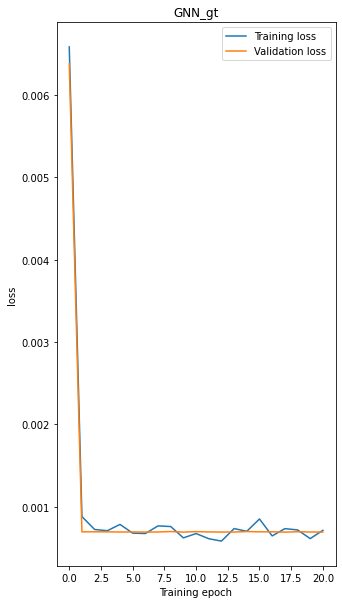

In [ ]:
# Instantiate a model with ground-truth connectivity.

# TASK: Instantatie a GNN with ground-truth adjacency connectivity.
#  ============ YOUR CODE HERE  ============
# model_gnn_gt = ...
model_gnn_gt = SimpleGCN(INPUT_DIM, OUTPUT_DIM, gcn_hidden_dim, num_layers=gcn_num_layers, adj_type="gt")
# ==========================================
model_gnn_gt = model_gnn_gt.to(DEVICE)

# Train the model.
train_stats = train_eval_loop(model_gnn_gt, train_loader, valid_loader, 
                                  test_loader, loss_fct=F.mse_loss, num_epochs=20,lr=LR)
# Visualise the training curve.
plot_stats(train_stats, name='GNN_gt', figsize=(5, 10))

## 🔭 Visualising predictions

Let's visualise what the learned trajectories look like, when compared to the ground-truth ones.

In [ ]:
#@title [RUN] Helper to visualise trajectories
def visualise_trajectory(trajectory, name=""):
    #trajectory: n_nodes x 2 x n_timesteps
    plt.figure(figsize=(4, 4), dpi=100)
    axes = plt.gca()
    axes.set_xlim([-4, 4])
    axes.set_ylim([-3, 3])

    start = 0.0
    stop = 1.0
    number_of_lines= 10
    cm_subsection = linspace(start, stop, number_of_lines) 

    colors = [ cm.Set1(x) for x in cm_subsection ]
    for i in range(test_sample.num_nodes):
        for t in range(num_steps):
            plt.plot(trajectory[i, 0, t], trajectory[i, 1, t], 'o', markersize=3, color=colors[i], alpha=1 -(float(t)/trajectory.shape[-1]))
        plt.plot(trajectory[i, 0, 0], trajectory[i, 1, 0], 'o', color=colors[i])
    plt.title(name)

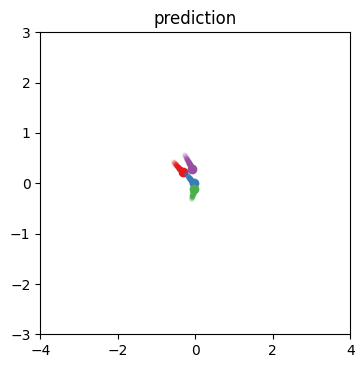

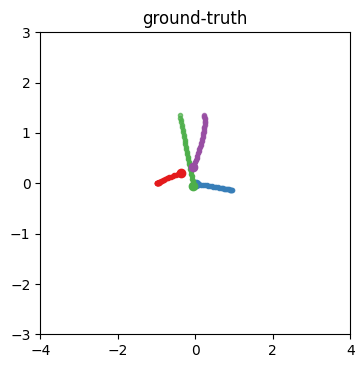

In [ ]:
#@title Plot one of the trajectories

example_index = 20#@param {type:"integer"}
num_steps = 30#@param {type:"integer"}

assert example_index >= 0 and example_index < len(test_dataset), \
    "Need valid dataset index!"

test_sample= test_dataset[example_index].to(DEVICE)
all_preds_tensor, _ = forward_step_pred(test_sample, model_gnn_gt, num_steps)
all_preds = all_preds_tensor.cpu().detach().numpy()
all_targets = test_sample.y.cpu()

visualise_trajectory(all_preds, name="prediction")
visualise_trajectory(all_targets, name="ground-truth")

## ⛏ Train using the **fully-connected** graph

The model provided above aligned well with how the simulation is generated. However, we do not always have access to the real connectivity (i.e. we do not always know the rules that underlie the evolution of the particle system). Most of the time, we only get to observe each node _individually_ (that is, the position of the each particle along the trajectory). But without the graph structure provided, we will not be able to apply a graph neural network! The usual workaround in this case is to assume a fully-connected graph, where each pair of particles _might_ influence each other. 

This translates to having an adjacency matrix full of ones. Let's train such a model:

In [ ]:
gcn_fc_hidden_dim = 17#@param {type:"integer"}
gcn_fc_num_layers = 2#@param {type:"integer"}
LR = 0.0005#@param {type:"number"}

[Epoch 0] train loss: 0.01448 val loss: 0.01429
[Epoch 1] train loss: 0.00080 val loss: 0.00082
[Epoch 11] train loss: 0.00080 val loss: 0.00082
Test metric long-term: 0.915


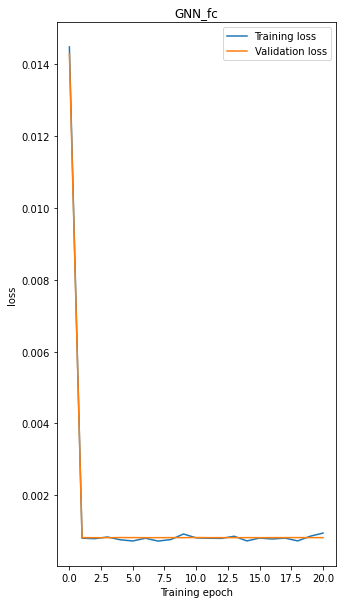

In [ ]:
# TASK: Instantiate a model with fully-connected connectivity.
# ============ YOUR CODE HERE  ============
# model_gnn_fully_graph =
model_gnn_fully_graph = SimpleGCN(INPUT_DIM, OUTPUT_DIM, gcn_fc_hidden_dim, num_layers=gcn_fc_num_layers, adj_type="fully_graph")
# =========================================
model_gnn_fully_graph = model_gnn_fully_graph.to(DEVICE)

# Train the model.
train_stats_fully_graph = train_eval_loop(model_gnn_fully_graph, train_loader, valid_loader, 
                                  test_loader, loss_fct=F.mse_loss, num_epochs=20,lr=LR)

# Visualise the training curve.
plot_stats(train_stats_fully_graph, name='GNN_fc', figsize=(5, 10))

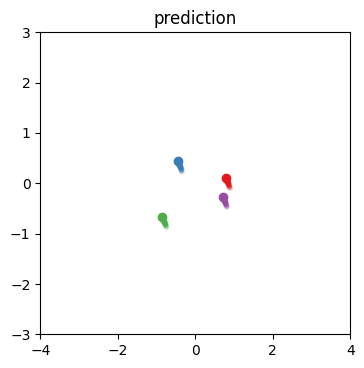

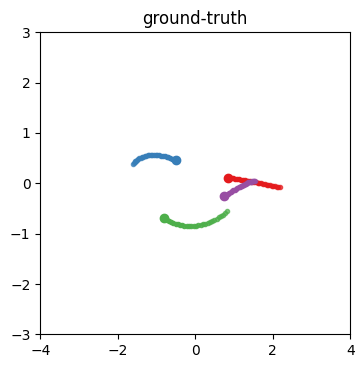

In [ ]:
#@title Plot one of the trajectories
example_index = 2#@param {type:"integer"}
num_steps = 30#@param {type:"integer"}

assert example_index >= 0 and example_index < len(test_dataset), \
    "Need valid dataset index!"

test_sample= test_dataset[example_index].to(DEVICE)
# all_preds: num_steps x num_nodes x dim
all_preds_tensor, _ = forward_step_pred(test_sample, model_gnn_fully_graph, num_steps)
all_preds = all_preds_tensor.cpu().detach().numpy()
all_targets = test_sample.y.cpu()

visualise_trajectory(all_preds, name="prediction")
visualise_trajectory(all_targets, name="ground-truth")

# 💡 Part 4: Coding a Message Passing Neural Network


Until now, we trained GCN models to predict particle trajectories, based on previous observations. One way to improve on this is by using a more powerful Graph Neural Network architecture.

One of the most general such architectures is the Message Passing Neural Network. This framework is based on 3 steps:
1. for each pair of 2 connected nodes, create a **message**;
2. for each node, **aggregate** the messages from its neighbourhood; 
3. **update** each node's representation using the corresponding aggregated messages.

The steps above are summarised by the following equation:

\begin{equation}
X_{k+1} = MLP_{upd}(\frac{1}{n_{edges}} \sum_j{MLP_{msg}({X_k}_i, {X_k}_j)})
\end{equation}




In [ ]:
class MPNNLayer(nn.Module):
    """ A Message Passing Layer. """
    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int):
        super(MPNNLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
    
        # Params for the nodes->edges function.
        self.linear1 = nn.Linear(self.in_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        # Params for the edges->nodes function.
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, self.out_feats)

    def forward(self, x, adj_matrix): 
        # x: n_timesteps x n_nodes (for the whole batch) x dim
        # adj_matrix: n_nodes x n_nodes
        
        adj_matrix = adj_matrix.unsqueeze(0).unsqueeze(-1)

        # Create messages for each pair of connected nodes.
        # We achieve all pairs of nodes (i,j) via broadcasting, by concatenating
        # (n_nodes x 1 x dim) || (1 x n_nodes x dim) -> (n_nodes x n_nodes x dim)
        feats_source = x.unsqueeze(2).tile((1,1,x.shape[1],1)) # n_timesteps x n_nodes x 1 x dim
        feats_dest =  x.unsqueeze(1).tile((1,x.shape[1],1,1)) # n_timesteps x 1 x n_nodes x dim
        feats_msg = torch.concat((feats_source, feats_dest), dim=-1) # n_timesteps x n_nodes x n_nodes x 2*dim

        # TASK: update the messages for each pair of nodes using a 2 layer MLP
        #  ============ YOUR CODE HERE  ============
        # feats_msg = ..
        feats_msg = F.relu(self.linear1(feats_msg)) # n_timesteps x n_nodes x n_nodes x dim
        feats_msg = self.linear2(feats_msg) # n_timesteps x n_nodes x n_nodes x 2*dim
        #  =========================================

        # To take into account the provided connectivity, mask the resulting
        # tensor with the adjacency matrix.
        feats_msg = feats_msg * adj_matrix  # n_timesteps x n_nodes x n_nodes x 2*dim 

        # Aggregate incoming messages via average pooling.
        feats_node = feats_msg.sum(axis=1) 
        feats_node = feats_node / adj_matrix.sum(1)

        # TASK: Update the node representation using a 2 layers MLP.
        #  ============ YOUR CODE HERE  ============
        # feats_node = ..
        feats_node = F.relu(self.linear3(feats_node))
        feats_node = self.linear4(feats_node)
        #  =========================================

        return feats_node

Let's create a Neural Network that uses MPNN Layers, in order to predict the change in position  Δ𝑥 :

In [ ]:
class SimpleMPNN(nn.Module):
    """ Simple MPNN network containing num_layers MPNN layers. """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, adj_type="gt"):
        super(SimpleMPNN, self).__init__()
        # Selects between ground-truth(gt) or fully-connected (fully_graph) node
        # connectivity.
        self.adj_type = adj_type
        assert adj_type in ['gt', 'fully_graph', '?']
        
        # NOTE: please select num_layers >= 2!
        self.num_layers = num_layers 

        # Project the spatial coordinates (x,y) into a larger space .
        self.embed_x = Linear(input_dim, hidden_dim)

        # TASK: instantiate `num_layers` MPNNLayer(s), each having a different set of parameters
        # ============ YOUR CODE HERE  ============
        # self.layers = nn.ModuleList(...)
        self.layers = [MPNNLayer(2*hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [MPNNLayer(2*hidden_dim, output_dim, hidden_dim)]
        self.layers = nn.ModuleList(self.layers)
        # =========================================

    def forward(self, input, adj_matrix):
        # x: n_timesteps x n_nodes x dim
        x = self.embed_x(input)

        for i in range(self.num_layers-1):
          x = self.layers[i](x, adj_matrix)
          x = F.relu(x)
        x = self.layers[-1](x, adj_matrix)
        
        # We are predicting the shift dx, not the future position. To obtain the
        # next prediction, add the input position.
        out = input + x

        # out: n_timesteps x n_nodes x dim
        return out

## 🛠 Train an MPNN for dynamic prediction

Let's train the model using the fully-connected graph. Despite our assumption about the structure, note that the MPNN is able to filter the neighbouring messages via `MLP_msg`, thus improving on the original connectivity. Unlike the MPNN, the GCN always aggregates messages from _all_ neighbours, which might lead to problems in the fully-connected setup!

In [ ]:
mpnn_hidden_dim = 17#@param {type:"integer"}
mpnn_num_layers =  2#@param {type:"integer"}
LR = 0.0005#@param {type:"number"}

[Epoch 0] train loss: 0.02383 val loss: 0.02346
[Epoch 1] train loss: 0.00087 val loss: 0.00076
[Epoch 11] train loss: 0.00066 val loss: 0.00074
Test metric long-term: 1.062


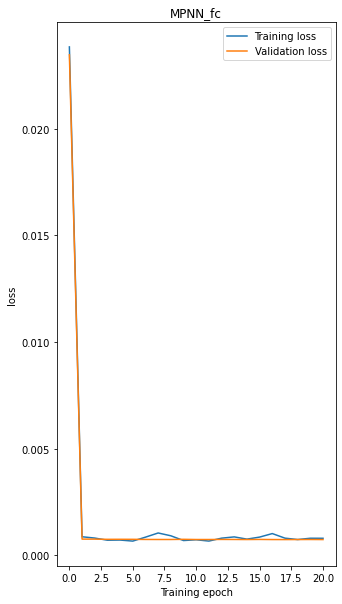

In [ ]:
# TASK: Instantiate an MPNN model with fully-connected structure.
# ============ YOUR CODE HERE  ============
# model_mpnn_gt = 
model_mpnn_gt = SimpleMPNN(INPUT_DIM, OUTPUT_DIM, mpnn_hidden_dim, num_layers=mpnn_num_layers, adj_type="fully_graph")
# =========================================
model_mpnn_gt = model_mpnn_gt.to(DEVICE)

# Train the model.
train_stats = train_eval_loop(model_mpnn_gt, train_loader, valid_loader, 
                                  test_loader, loss_fct=F.mse_loss, num_epochs=20,lr=LR)

# Visualise the training curve.
plot_stats(train_stats, name='MPNN_fc', figsize=(5, 10))

## 🔭 Visualise the predicted trajectories

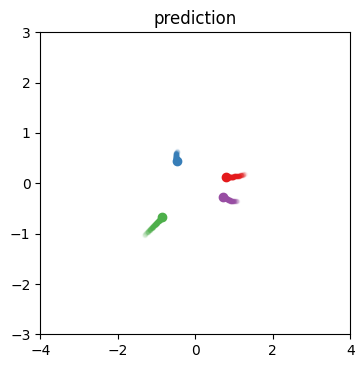

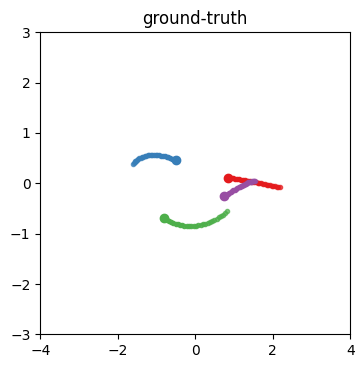

In [ ]:
#@title Plot one of the trajectories
example_index = 2#@param {type:"integer"}
num_steps = 30#@param {type:"integer"}

assert example_index >= 0 and example_index < len(test_dataset), \
    "Need valid dataset index!"

test_sample= test_dataset[example_index].to(DEVICE)
all_preds_tensor, _ = forward_step_pred(test_sample, model_mpnn_gt, num_steps)
all_preds = all_preds_tensor.cpu().detach().numpy()
all_targets = test_sample.y.cpu()

visualise_trajectory(all_preds, name="prediction")
visualise_trajectory(all_targets, name="ground-truth")

# 🆒 BONUS: Predict the connectivity with an NRI-like model

Without knowing the graph structure, assuming fully-connected interaction is a simple but _very weak_ prior. A different approach is learning to _predict_ the connectivity and use this predicted structure during graph processing. 

However, if the ground-truth connectivity is not available, we need to design an end-to-end differentiable graph predictor such that the graph connectivity is learned using only the final, node-level supervision.




**Architecture.** One of the most popular approaches for this task is the Neural Relation Inference (NRI) model, which contains 2 parts:

1) An **encoder**, to predict the graph connectivity;

2) A **decoder**, which uses the connectivity predicted by the encoder to predict the trajectory (similar to the models used before).

<center>
<img src="https://drive.google.com/uc?export=view&id=1t0AKZOzv43NhfBx4gbIMPhTuO2dRuPN3" width="800">
</center>

For the encoder architecture we will adopt an MPNN architecture that tries to predict the graph structure based on a sequence of observations.

The model receives as input a single fully-connected graph. The features for each particle / node are obtained by concatenating the features for that particle along the trajectory $x_i \in \mathbb{R}^{2~\times~n_{timesteps}} $. Instead of predicting the features for each node, the encoder uses the representation of each pair of nodes to predict a score. This score, given by the equation below, is then used to _sample_ the graph structure.

\begin{equation}
h_{i,j} = \text{softmax}(\text{MLP}_{edge}(h_i, h_j))
\end{equation}



For each edge, scores obtained by the encoder are used to sample the graph structure (0/1 denoting the absence/presence of the edge). However, the classical operation of sampling from a distribution is not differentiable. To be able to backpropagate the gradient through the model, we will used [Gumble Softmax](https://en.wikipedia.org/wiki/Gumbel_distribution) as a sampler (a relaxed version of the categorical distribution):

\begin{equation}
  g_k = \text{Gumble}(0,1) \\
  z_{i,j} = \text{softmax}((h_{i,j} + g) / \tau) 
\end{equation}

In [ ]:
class EdgeMPNNLayer(nn.Module):
    """ An MPNN layer producing a representation for each edge h_{i,j}. """
    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int):
        super(EdgeMPNNLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
    
        self.linear1 = nn.Linear(self.in_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 2) # edge or no edge

    def forward(self, x, adj_matrix): 
        # x: n_nodes (for the whole batch) x dim
        # adj_matrix: n_nodes x n_nodes
        adj_matrix = adj_matrix.unsqueeze(-1)
        
        # Create messages for each pair of connected nodes
        # we achieve all pairs of nodes (i,j) via broadcasting by concatenating
        # (n_nodes x 1 x dim) || (1 x n_nodes x dim) -> (n_nodes x n_nodes x dim)
        feats_source = x.unsqueeze(1).tile((1,x.shape[0],1)) # n_nodes x 1 x dim
        feats_dest =  x.unsqueeze(0).tile((x.shape[0],1,1)) # 1 x n_nodes x dim
        feats_msg = torch.concat((feats_source, feats_dest), dim=-1) # n_nodes x n_nodes x 2*dim

        # TASK: update the messages for each pair of nodes using a 2 layer MLP
        # ============ YOUR CODE HERE  ============
        # feats_msg = ..
        feats_msg = F.relu(self.linear1(feats_msg)) # n_nodes x n_nodes x hidden_dim
        feats_msg = self.linear2(feats_msg) # n_nodes x n_nodes x 2
        # =========================================

        # To account for the provided connectivity, we masked the resulting
        # tensor with the adjacency matrix. The 2 outputs (logits) correspond to
        # probabilities of (not) having an edge between (i,j).

        # By default, `adj_matrix` is a matrix full of ones.
        feats_msg = feats_msg * adj_matrix  # n_nodes x n_nodes x 2

        return feats_msg

In [ ]:
class SimpleMPNNEncoder(nn.Module):
    """ The MPNN Encoder predicting the graph structure. """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2):
        super(SimpleMPNNEncoder, self).__init__()
        
        self.num_layers = num_layers  
        assert self.num_layers >= 2

        self.embed_x = Linear(input_dim, hidden_dim)

        # TASK: instantiate `num_layers-1` MPNNLayer(s), each having a different set of parameters
        # ============ YOUR CODE HERE  ============
        # self.layers = ..
        self.layers = [MPNNLayer(2*hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        # =========================================

        # TASK: The last layer is an EdgeMPNNLayer for edge-level predictions.
        # ============ YOUR CODE HERE  ============
        # self.layers += ..
        self.layers += [EdgeMPNNLayer(2*hidden_dim, output_dim, hidden_dim)]
        # =========================================
        self.layers = nn.ModuleList(self.layers)

    def forward(self, input, batch):
        # create fully connectivity per graph 
        # (do not connect nodes from different samples belonging to the same batch)
        adj_matrix = torch.ones((input.shape[1], input.shape[1])).to(DEVICE)
        if batch is not None:
          tozero = batch.unsqueeze(0) != batch.unsqueeze(1)
          diag_ids = torch.arange(adj_matrix.shape[0])
          adj_matrix[tozero] = 0
          adj_matrix[diag_ids, diag_ids] = 0
        # x: n_timesteps x n_nodes x dim ->  n_nodes x dim x n_timesteps
        x = torch.permute(input, (1,2,0)).contiguous()
        
        # Merge the last 2 dimension. The graph prediction should be made based
        # on the entire sequence.
        x = x.view((x.shape[0],-1))
        x = self.embed_x(x).unsqueeze(0)

        for i in range(self.num_layers-1):
          x = self.layers[i](x, adj_matrix)
          x = F.relu(x)
        
        # x: 1 x n_nodes x dim
        x = x.squeeze(0)
        out = self.layers[-1](x, adj_matrix)
        # out: n_nodes x n_nodes x 2
        return out

We provide the code for the Gumble softmax sampling:

In [ ]:
#@title [RUN] helper functions for sampling the adjacency

from torch.autograd import Variable

def my_softmax(input, axis=1):
    soft_max_1d = F.softmax(input, axis)
    return soft_max_1d 
    
def sample_gumbel(shape, eps=1e-10):
    """
    NOTE: Taken from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Sample from Gumbel(0, 1)
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    U = torch.rand(shape).float()
    gumbels = - torch.log(eps - torch.log(U + eps))
    return gumbels


def gumbel_softmax_sample(logits, tau=1, eps=1e-10):
    """
    NOTE: Taken from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Draw a sample from the Gumbel-Softmax distribution
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb
    (MIT license)
    """
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    y = logits + Variable(gumbel_noise).to(DEVICE)
    return my_softmax(y / tau, axis=-1)


def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):
    """
    NOTE: Taken from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
      logits: [batch_size, n_class] unnormalized log-probs
      logits: [num_timesteps, n_nodes, n_nodes, 2] unnormalized log-probs
      tau: non-negative scalar temperature
      hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probability distribution that sums to 1 across classes
    Constraints:
    - this implementation only works on batch_size x num_features tensor for now
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    y_soft = gumbel_softmax_sample(logits, tau=tau, eps=eps)
    if hard:
        shape = logits.size()
        _, k = y_soft.data.max(-1)
        # this bit is based on
        # https://discuss.pytorch.org/t/stop-gradients-for-st-gumbel-softmax/530/5
        y_hard = torch.zeros(*shape).to(DEVICE)
        y_hard = y_hard.zero_().scatter_(-1, k.view(shape[:-1] + (1,)), 1.0).to(DEVICE)
        # this cool bit of code achieves two things:
        # - makes the output value exactly one-hot (since we add then
        #   subtract y_soft value)
        # - makes the gradient equal to y_soft gradient (since we strip
        #   all other gradients)
        y = Variable(y_hard - y_soft.data).to(DEVICE) + y_soft
    else:
        y = y_soft
    return y


Let's use the encoder-decoder architecture to predict the trajectories. We will modify the forward pass such that it first predicts the adjacency matrix and then uses it to indicate the connectivity, instead of what `adj_type` suggests.

**Training procedure.** Following the approach used in the original paper, during *training*, both the encoder and the decoder receive as input the entire trajectory. For the final *evaluation* to be applicable in practice, the encoder receives only the first half of the trajectory, while the decoder predicts the other half.

In [ ]:
import torch.optim as optim

def forward_step_teacher_forcing_nri(batch, model_adj, model):
    """ One feed-forward step using teacher-forcing (TRAIN only).

    During training, we use a teacher-forcing approach, where at each time step
    t, we feed as input the real position from the previous timestep t-1.

    The model is an encoder-decoder architecture: 
    - first, the encoder predicts the structure probabilities;
    - then, the Gumbel Softmax is used to sample the structure;
    - finally, the predicted structure is used to predict the trajectory.

    Output: (pred, target) tuple.
    """

    # During training, the encoder receives the whole trajectory.
    feats = batch.x.reshape(batch.x.shape[0], INPUT_DIM, -1)
    feats = torch.permute(feats, [2,0,1])

    # Encoder: predict the graph structure.
    adj_matrix = model_adj(feats, batch.batch)  #n_nodes x n_nodes x 2
    adj_matrix = gumbel_softmax(adj_matrix, tau=1, hard=True)
    # Since we only have one type of edge, we can do this.
    adj_matrix = adj_matrix[:,:,0] + torch.eye(batch.num_nodes).to(DEVICE) #n_nodes x n_nodes

    # Decoder: uses the predicted structure to predict the trajectory.
    y_hat  = model(feats, adj_matrix)
    y_hat = y_hat.permute((1,2,0))
    return y_hat, batch.y

def forward_step_pred_nri(batch, model_adj, model, timesteps=TIMESTEPS):
    """ One feed-forward step using previous predictions as inputs (EVAL only);
   `run for the first `timesteps` position in the input.

    During training, we use a teacher-forcing approach, where at each time step
    t, we feed as input the real position from the previous timestep t-1.

    The model is an encoder-decoder architecture: 
    - first, the encoder predicts the structure probabilities;
    - then, the Gumbel Softmax is used to sample the structure;
    - finally, the predicted structure is used to predict the trajectory.

    Output: (pred, target) tuple.
    """

    feats = batch.x.reshape(batch.x.shape[0], INPUT_DIM, -1)
    # feats: n_nodes x dim x n_timesteps
    assert(feats.shape[-1] >= 2*timesteps)

    # During testing, the encoder receives the first half of the trajectory.
    feats_enc = feats[:,:,:timesteps]
    # The decoder predicts the second half of the trajectory.
    feats_dec = feats[:,:,-timesteps:]
  
    feats_enc = torch.permute(feats_enc, [2,0,1])
    feats_dec = torch.permute(feats_dec, [2,0,1])[0,:,:].unsqueeze(0)
    
    # Encoder: predict the graph structure.
    adj_matrix = model_adj(feats_enc, batch.batch) 
    adj_matrix = gumbel_softmax(adj_matrix, tau=1, hard=True)
    # Since we only have one type of edge, we can extract the probability of
    # existence from the first position.
    adj_matrix = adj_matrix[:,:,0] + torch.eye(batch.num_nodes).to(DEVICE)

    # Decoder: uses the predicted structure to predict the trajectory.
    all_y_hat = []
    for i in range(timesteps):
      feats_dec  = model(feats_dec, adj_matrix)
      all_y_hat.append(feats_dec)
    
    all_y_hat = torch.cat(all_y_hat, 0)
    all_y_hat = all_y_hat.permute((1,2,0))

    # n_nodes x dim x n_timesteps
    return all_y_hat, batch.y[:,:,-timesteps:]

def train_epoch_nri(data_loader, model_adj, model, optimiser, epoch, loss_fct):
    """ Train the model for one epoch. """
    model.train()
    num_iter = len(data_loader)

    for i, batch in enumerate(data_loader):
        batch = batch.to(DEVICE)
        optimiser.zero_grad()
        # For training, we are always using teacher forcing.
        y_hat,y = forward_step_teacher_forcing_nri(batch, model_adj, model)
        loss = loss_fct(y_hat, y)
        loss.backward()
        optimiser.step()

    return loss.data

def eval_epoch_nri(data_loader, model_adj, model, loss_fct, forward_fct):
    """ Evaluate the model on the dataset. """
    model.eval()
    num_iter = len(data_loader)
    loss_eval = 0

    for i, batch in enumerate(data_loader):
        # For evaluation, we can switch between using the gt (teacher forcing)
        # or the prediction as an input to the next state.
        batch = batch.to(DEVICE)
        y_hat,y = forward_fct(batch, model_adj, model)
        loss = loss_fct(y_hat, y)
        loss_eval += loss.data

    loss_eval /= num_iter
    return loss_eval

def train_eval_loop_nri(model_adj, model, train_loader, val_loader, test_loader, 
               loss_fct, num_epochs=100,lr=0.0005):
    """ Train the model for num_epochs epochs. """
    # Instantiatie our optimiser.
    optimiser = optim.Adam(
        list(model.parameters()) + list(model_adj.parameters()), lr=lr)
    training_stats = None

    # Initial evaluation (before training).
    val_loss = eval_epoch_nri(val_loader,
                              model_adj,
                              model,
                              loss_fct,
                              forward_step_teacher_forcing_nri)
    train_loss = eval_epoch_nri(train_loader,
                                model_adj,
                                model,
                                loss_fct,
                                forward_step_teacher_forcing_nri)

    
    epoch_stats = {
        'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(), 'epoch': 0
    }
    training_stats = update_stats(training_stats, epoch_stats)
    print(f"[Epoch 0]",
          f"train loss: {train_loss:.5f} val loss: {val_loss:.5f}")

    for epoch in range(num_epochs):
        train_loss  = train_epoch_nri(train_loader,
                                      model_adj,
                                      model,
                                      optimiser,
                                      epoch, 
                                      loss_fct)
        
        val_loss = eval_epoch_nri(val_loader,
                                  model_adj,
                                  model,
                                  loss_fct,
                                  forward_step_teacher_forcing_nri)

        if epoch % 10 == 0:
          print(f"[Epoch {epoch+1}]",
                f"train loss: {train_loss:.5f} val loss: {val_loss:.5f}")
        # Store the loss and the computed metric for the final plot.
        epoch_stats = {
            'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(), 'epoch': epoch + 1
        }
        training_stats = update_stats(training_stats, epoch_stats)
    
    # Evaluate the model on the test split
    test_loss_long_term = eval_epoch_nri(
        test_loader, model_adj, model,  loss_fct, forward_step_pred_nri)
    print(f"Test metric long term: {test_loss_long_term:.3f}")
    return training_stats

## 🛠 Train the NRI model with simple MSE loss

Let's train the model:

In [ ]:
nri_simple_hidden_dim = 16#@param {type:"integer"}
nri_simple_num_layers = 2#@param {type:"integer"}
LR = 0.0005#@param {type:"number"}

[Epoch 0] train loss: 0.01021 val loss: 0.00994
[Epoch 1] train loss: 0.00086 val loss: 0.00078
[Epoch 11] train loss: 0.00054 val loss: 0.00076
Test metric long term: 0.595


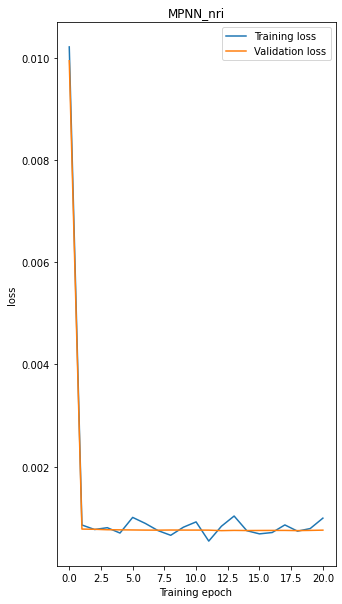

In [ ]:
# TASK: Instantiate the MPNN Decoder (same as the one used before) and the MPNN Encoder. ; `adj_type` is
# ignored since we are using the predicted one.
# ============ YOUR CODE HERE  ============
# model_nri = ..
# model_adj_nri = ..

model_nri = SimpleMPNN(INPUT_DIM, OUTPUT_DIM, nri_simple_hidden_dim, num_layers=nri_simple_num_layers, adj_type="fully_graph")

model_adj_nri = SimpleMPNNEncoder(INPUT_DIM*TIMESTEPS, OUTPUT_DIM, nri_simple_hidden_dim, num_layers=nri_simple_num_layers)
# ==========================================
model_nri = model_nri.to(DEVICE)
model_adj_nri = model_adj_nri.to(DEVICE)

# Train the model.
train_stats = train_eval_loop_nri(model_adj_nri, model_nri, train_loader, valid_loader, 
                                  test_loader, loss_fct=F.mse_loss, num_epochs=20,lr=LR)

# Plot the training curve.
plot_stats(train_stats, name='MPNN_nri', figsize=(5, 10))

## 🔭 Visualise the trajectories

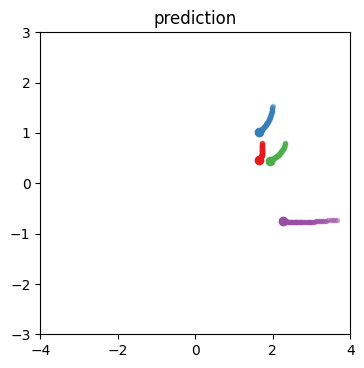

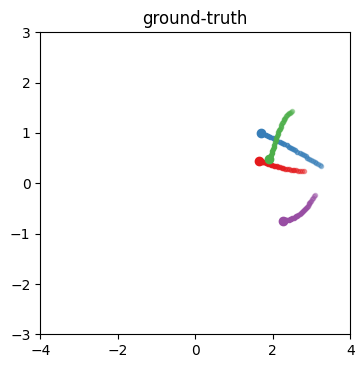

In [65]:
#@title Plot one of the trajectories
example_index = 13#@param {type:"integer"}

assert example_index >= 0 and example_index < len(test_dataset), \
    "Need valid dataset index!"

test_sample= test_dataset[example_index].to(DEVICE)
# all_preds: n_timesteps x n_nodes x dim
all_preds_tensor, all_targets_tensor = forward_step_pred_nri(test_sample, model_adj_nri, model_nri)
all_preds = all_preds_tensor.cpu().detach().numpy()

all_targets = all_targets_tensor.cpu().detach().numpy()

visualise_trajectory(all_preds, name="prediction")
visualise_trajectory(all_targets, name="ground-truth")

## 🛠 Train NRI with ELBO loss

**ELBO loss function.** The original NRI model formalises the training as a variational autoencoder (VAE), using ELBO as an objective:

<center>
<img src="https://drive.google.com/uc?export=view&id=1n7VDaebgX2EOSl_KtKYgEtjgTA7NjwTt" width="500">
</center>

The first term is a **reconstruction** term, ensuring that the prediction is accurate, while the second term is a **regularisation** term, ensuring that the distribution of the graph is close to the prior.

The reconstruction term could be estimated by
<center>
<img src="https://drive.google.com/uc?export=view&id=1CJYp5sjvp2LmX33OSxlYkQfQHpJWNscs" width="250">
</center>

For an uniform prior, the second term becomes the sum of the entropies:

<center>
<img src="https://drive.google.com/uc?export=view&id=1_f6AKWpmrmrS88PGEjdxUZHsjzKtFT3m" width="250">
</center>





<details>
<summary> 💻 <b>Q:</b> Try to prove that the KL loss for the uniform prior leads to the sum of entropies (plus a constant). </summary>

 **A:** 
 
 \begin{align}
 KL(q(z|x)||u(z)) &= \sum_z q(z|x) log(\frac{q(z|x)}{u(z)}) \\
  &= \sum_z q(z|x) log(q(z|x))-\sum_z q(z|x)log({u(z)}) \\ 
  &=\sum_z q(z|x) log(q(z|x))-\sum_z q(z|x)log(\frac{1}{2})) \\
  &=\sum_z q(z|x) log(q(z|x))+\sum_z q(z|x)log(2) \\
  &=\sum_z q(z|x) log(q(z|x))+log(2) \\
  &=-H(q(z|x))+log(2) \\
 \end{align}

</details>


In [66]:
def kl_categorical_uniform(preds, num_nodes, eps=1e-16):
    preds = preds.view(-1, preds.shape[-1])
    kl_div = preds * torch.log(preds + eps)
    return kl_div.sum() / (num_nodes * preds.size(0))

In [67]:
import torch.optim as optim

def forward_step_teacher_forcing_nri_elbo(batch, model_adj, model):
    # For training, use the whole sequence to predict the graph structure.
    feats = batch.x.reshape(batch.x.shape[0], INPUT_DIM, -1)
    feats = torch.permute(feats, [2,0,1])

    # Encoder: predict the graph structure.
    adj_matrix_logits = model_adj(feats, batch.batch)  # n_nodes x n_nodes x 2
    adj_matrix = gumbel_softmax(adj_matrix_logits, tau=1, hard=True)
    adj_matrix_prob = my_softmax(adj_matrix_logits, -1) # n_nodes x n_nodes x 2

    
    # Since we only have one type of edge, we can extract the probability of
    # an edge from the first position.
    adj_matrix = adj_matrix[:,:,0]

    # Decoder: uses the predicted structure to predict the trajectory.
    y_hat  = model(feats, adj_matrix)
    y_hat = y_hat.permute((1,2,0))
    return y_hat, batch.y[:,:,-timesteps:], adj_matrix_prob

def forward_step_pred_nri_elbo(batch, model_adj, model, timesteps=TIMESTEPS):
    feats = batch.x.reshape(batch.x.shape[0], INPUT_DIM, -1)
    # feats: n_nodes x dim x n_timesteps
    assert(feats.shape[-1] >= 2*timesteps)

    # For final evaluation, the encoder receives the 1st half of the trajectory.
    feats_enc = feats[:,:,:timesteps]
    # The decoder predicts the 2nd half of the trajectory.
    feats_dec = feats[:,:,-timesteps:]
    
    feats_enc = torch.permute(feats_enc, [2,0,1]) 
    feats_dec = torch.permute(feats_dec, [2,0,1])[0,:,:].unsqueeze(0)
    
    # Encoder: predict the graph structure.
    adj_matrix_logits = model_adj(feats_enc, batch.batch) 
    adj_matrix = gumbel_softmax(adj_matrix_logits, tau=1, hard=True)
    adj_matrix_prob = my_softmax(adj_matrix_logits, -1) # n_nodes x n_nodes x 2

    # Since we only have one type of edge, we can do this.
    adj_matrix = adj_matrix[:,:,0]

    # Decoder: use the predicted structure to predict the trajectory.
    all_y_hat = []
    for i in range(timesteps):
      feats_dec  = model(feats_dec, adj_matrix)
      all_y_hat.append(feats_dec)
    
    all_y_hat = torch.cat(all_y_hat, 0)
    all_y_hat = all_y_hat.permute((1,2,0))

    # n_nodes x dim x n_timesteps
    return all_y_hat, batch.y[:,:,-timesteps:], adj_matrix_prob

def train_epoch_nri_elbo(data_loader, model_adj, model, optimiser, epoch, loss_fct):
    """ Train model for one epoch. """
    model.train()
    num_iter = len(data_loader)

    for i, batch in enumerate(data_loader):
        batch = batch.to(DEVICE)
        optimiser.zero_grad()
        # During training we alwways use teacher forcing.
        y_hat, y, adj_matrix_prob = forward_step_teacher_forcing_nri_elbo(batch, model_adj, model)
        loss_rec = loss_fct(y_hat, y)
        # TASK: compute the kl regularisation loss
        # ============ YOUR CODE HERE  ============
        # loss_kl = ..
        loss_kl = kl_categorical_uniform(adj_matrix_prob, batch.x.shape[0])
        # =========================================
        loss = loss_rec + loss_kl

        loss.backward()
        optimiser.step()

    return loss.data

def eval_epoch_nri_elbo(data_loader, model_adj, model, loss_fct, forward_fct):
    """ Evaluate model on dataset. """
    model.eval()
    num_iter = len(data_loader)
    loss_eval = 0

    for i, batch in enumerate(data_loader):
        # During evaluation we can switch between using the gt (teacher forcing)
        # or the prediction as input for the next step.
        batch = batch.to(DEVICE)
        y_hat, y, _ = forward_fct(batch, model_adj, model)
        loss = loss_fct(y_hat, y)
        loss_eval += loss.data

    loss_eval /= num_iter
    return loss_eval

def train_eval_loop_nri_elbo(model_adj, model, train_loader, val_loader, test_loader, 
               loss_fct, num_epochs=100,lr=0.0005):
    """ Train the model for num_epochs epochs. """
    # Instantiate our optimiser.
    optimiser = optim.Adam(list(model.parameters()) + list(model_adj.parameters()), lr=lr)
    training_stats = None

    # Initial evaluation (before training).
    val_loss = eval_epoch_nri_elbo(val_loader,
                                   model_adj,
                                   model,
                                   loss_fct,
                                   forward_step_teacher_forcing_nri_elbo)
    train_loss = eval_epoch_nri_elbo(train_loader,
                                     model_adj,
                                     model,
                                     loss_fct,
                                     forward_step_teacher_forcing_nri_elbo)
    
    epoch_stats = {
        'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(), 'epoch': 0
    }
    training_stats = update_stats(training_stats, epoch_stats)
    print(f"[Epoch 0]",
          f"train loss: {train_loss:.5f} val loss: {val_loss:.5f}")

    for epoch in range(num_epochs):
        train_loss  = train_epoch_nri_elbo(train_loader,
                                           model_adj,
                                           model,
                                           optimiser,
                                           epoch, 
                                           loss_fct)
        
        val_loss = eval_epoch_nri_elbo(val_loader,
                                       model_adj,
                                       model,
                                       loss_fct,
                                       forward_step_teacher_forcing_nri_elbo)

        if epoch % 10 == 0:
          print(f"[Epoch {epoch+1}]",
                f"train loss: {train_loss:.5f} val loss: {val_loss:.5f}")
        # store the loss and the computed metric for the final plot
        epoch_stats = {
            'train_loss': train_loss.cpu(), 'val_loss': val_loss.cpu(), 'epoch': epoch+1
        }
        training_stats = update_stats(training_stats, epoch_stats)
    
    test_loss_long_term = eval_epoch_nri_elbo(test_loader,
                                              model_adj,
                                              model,
                                              loss_fct,
                                              forward_step_pred_nri_elbo)

    print(f"Test metric long term: {test_loss_long_term:.3f}")
    return training_stats

Let's train the model:

In [68]:
nri_hidden_dim = 16#@param {type:"integer"}
nri_num_layers = 2#@param {type:"integer"}
LR = 0.0005#@param {type:"number"}

[Epoch 0] train loss: 0.04485 val loss: 0.04501
[Epoch 1] train loss: -0.01839 val loss: 0.00079
[Epoch 11] train loss: -0.01843 val loss: 0.00077
Test metric long term: 0.632


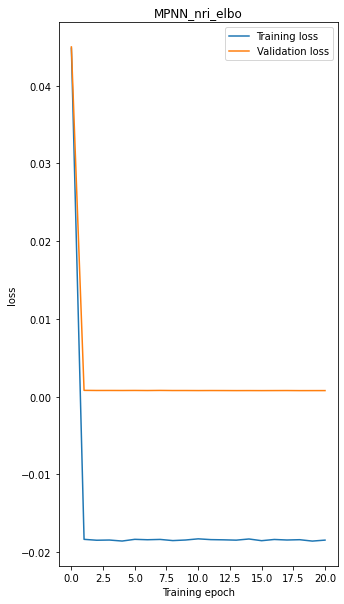

In [69]:
# TASK: Instantiate the MPNN Decoder (same as the one used before) and the MPNN Encoder. ; `adj_type` is
# ignored since we are using the predicted one.
# ============ YOUR CODE HERE  ============
# model_nri_elbo = ..
# model_adj_nri_elbo = ..

model_nri_elbo = SimpleMPNN(INPUT_DIM,
                            OUTPUT_DIM,
                            nri_hidden_dim,
                            num_layers=nri_num_layers,
                            adj_type="?")

model_adj_nri_elbo = SimpleMPNNEncoder(INPUT_DIM*TIMESTEPS,
                                       OUTPUT_DIM,
                                       nri_hidden_dim,
                                       num_layers=nri_num_layers)
# ===========================================
model_nri_elbo = model_nri_elbo.to(DEVICE)
model_adj_nri_elbo = model_adj_nri_elbo.to(DEVICE)
                                        
# Train the model
train_stats = train_eval_loop_nri_elbo(model_adj_nri_elbo,
                                       model_nri_elbo,
                                       train_loader,
                                       valid_loader,
                                       test_loader,
                                       loss_fct=F.mse_loss,
                                       num_epochs=20,lr=LR)

# Plot the training curve
plot_stats(train_stats, name='MPNN_nri_elbo', figsize=(5, 10))

## 🔭 Visualise the trajectories

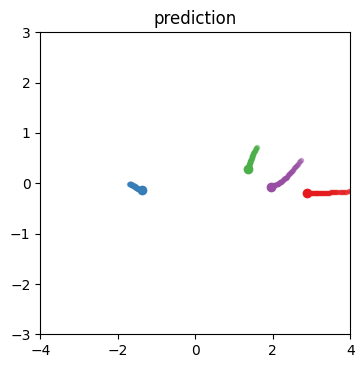

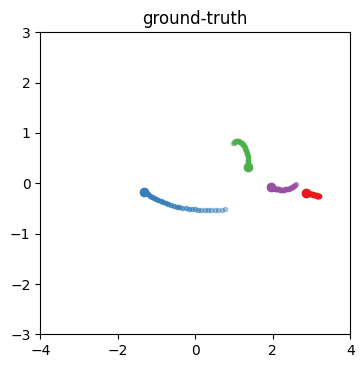

In [70]:
#@title Plot one of the trajectories
example_index =  2#@param {type:"integer"}
num_steps =  30#@param {type:"integer"}

assert example_index >= 0 and example_index < len(test_dataset), \
    "Need valid dataset index!"

test_sample= test_dataset[example_index].to(DEVICE)
all_preds_tensor, all_targets_tensor, _ = forward_step_pred_nri_elbo(test_sample, model_adj_nri_elbo, model_nri_elbo)
all_preds = all_preds_tensor.cpu().detach().numpy()

all_targets = all_targets_tensor.cpu().detach().numpy()

visualise_trajectory(all_preds, name="prediction")
visualise_trajectory(all_targets, name="ground-truth")

## Additional resources (this is, of course, a non-exhaustive list!)

1. Chaitanya Joshi's [blog post](https://graphdeeplearning.github.io/post/transformers-are-gnns/) on the link between GNNs and Transformers (2020).
2. Xavier Bresson's [slide deck](https://www.dropbox.com/s/u82gcg3aath39hp/GNN_applications_Jun21.pdf?dl=0) on GNN applications (2021).
3. Michael Bronstein's [TDS post](https://towardsdatascience.com/do-we-need-deep-graph-neural-networks-be62d3ec5c59) on whether we should 'stack more layers' in GNNs.

## Acknowledgements

We would like to thank [Thomas Kipf](https://tkipf.github.io/) for discussing the structure of this tutorial and for offering feedback and access to the original NRI codebase.